In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.datasets
import utils

from nn_framework.op import Variable, Const, Placeholder, ReLU, Sigmoid, GradientDescentOptimizer, Ones, LogisticLoss

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
class Session(object):
  def run(self, expressions, feeds):
    cache = {}
    return [exp.eval(feeds, cache) for exp in expressions]

In [3]:
def dense(X, input_dim, output_dim):
  W = Variable(np.random.randn(output_dim, input_dim) * 0.01)
  b = Variable(np.zeros([output_dim, 1]))
  return W.dot(X) + b

X.shape = (2, 1000), Y.shape = (1, 1000)


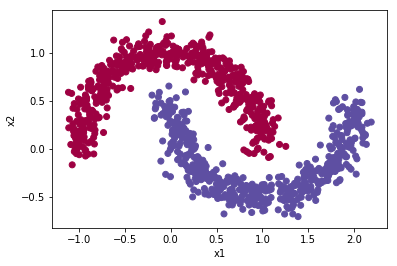

In [4]:
# m = 100
# X = np.ones([2, m]) + 10
# X[:, m // 2:] += 10
# X += np.random.randn(X.shape[0], X.shape[1]) * 3
# Y = np.hstack([np.zeros((1, m // 2)), np.ones((1, m // 2))])
# X /= 25

X, Y = sklearn.datasets.make_moons(1000, noise=0.1)
X = X.T
Y = Y.reshape(-1, 1).T

print('X.shape = %s, Y.shape = %s' % (X.shape, Y.shape))
plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral)
plt.ylabel('x2')
plt.xlabel('x1')

In [6]:
def dot_grads(var, a, b, name):
  with tf.name_scope(name):
    fill = tf.fill((n_h, m), 1.)
    with tf.name_scope('matmul_grad'):
      da_target = tf.matmul(fill, b, transpose_b=True)
      db_target = tf.matmul(fill, a, transpose_a=True)
      
    [da] = tf.gradients(a, [var], da_target, name='da')
    [db] = tf.gradients(b, [var], tf.transpose(db_target), name='db')

    if da is None:
      return db
    elif db is None:
      return da
    else:
      return tf.add_n([da, db])

tf.reset_default_graph()
m = 1000
n = 2
n_h = 5

w = tf.random_normal((n_h, n), name='w')

a = tf.identity(w * 2, name='a')
# b = tf.random_normal((n, m), name='b')
b = tf.identity(tf.matmul(tf.random_normal((n, n_h)), tf.matmul(w, tf.random_normal((n, m)))), name='b')

z = tf.matmul(a, b)
# dz = tf.random_normal((2, 2))
[dw] = tf.gradients(z, [w], name='dw') # aggregation_method=tf.AggregationMethod.ADD_N
dw_comp = dot_grads(w, a, b, name='dw_comp')

with tf.Session() as sess:
  writer = tf.summary.FileWriter('/tmp/tf_log/nn_framework_experiments', sess.graph)
  writer.close()
  
  dw_mse = tf.reduce_mean(tf.square(dw - dw_comp))
  [dw_mse_val, dw_val, dw_comp_val] = sess.run([dw_mse, dw, dw_comp])
  assert(dw_val.shape == dw_comp_val.shape)
  print('dw mse: %s' % dw_mse_val)
  
  
w = np.random.randn(n_h, n)
t1 = np.random.randn(n, n_h)
t2 = np.random.randn(n, m)

# TensorFlow
wtf = tf.constant(w)
atf = wtf * 2
atf *= atf
btf = (tf.matmul(t1, tf.matmul(wtf, t2)) + 1) * 2 - 3
btf *= btf

ztf = tf.matmul(atf, btf)
ztf *= ztf
[dwtf] = tf.gradients(ztf, [wtf])

# My :D
wmy = Variable(w)
amy = wmy * Const(2)
amy *= amy
bmy = (Const(t1).dot(wmy.dot(Const(t2))) + Const(1)) * Const(2) - Const(3)
bmy *= bmy

zmy = amy.dot(bmy)
zmy *= zmy
dwmy = zmy.deriv(wmy, Ones(zmy.shape))

# s = zmy.shape
# s.eval({}, {})

with tf.Session() as sess:
  [dwtf_val] = sess.run([dwtf])
  [dwmy_val] = Session().run([dwmy], {})
  
  dw_mse = np.mean(np.square(dwtf_val - dwmy_val))
  
  print('actual test (mse): %s' % dw_mse)

dw mse: 0.0
actual test (mse): 6.17106366008e-13


In [10]:
learning_rate = 0.001
steps = 100

A0 = Placeholder('X')
Z1 = dense(A0, input_dim=X.shape[0], output_dim=20)
A1 = ReLU(Z1)
Z2 = dense(A1, input_dim=20, output_dim=10)
A2 = ReLU(Z2)
Z3 = dense(A2, input_dim=10, output_dim=1)  
A3 = Sigmoid(Z3)
Y_hat = A3

loss = LogisticLoss(A=Y_hat, Y=Const(Y))
assert len(loss.variables) == 2 * 3

train = GradientDescentOptimizer(learning_rate, loss)

sess = Session()
print('loss: %f' % sess.run([loss], {A0: X})[0])

for i in range(0, steps):
  _, l, Y_hat_val = sess.run([train, loss, Y_hat], {A0: X})
  if i % 10 == 0:
    acc = np.mean(Y == (Y_hat_val > 0.5)) * 100
    print('step: %d, loss: %f, accuracy: %s' % (i, l, acc))

(1, 1000)
loss: 0.693148
(1, 1000)
step: 0, loss: 0.693148, accuracy: 24.5
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 10, loss: 0.693146, accuracy: 85.8
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 20, loss: 0.693143, accuracy: 100.0
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 30, loss: 0.693141, accuracy: 100.0
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 40, loss: 0.693138, accuracy: 100.0
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 50, loss: 0.693136, accuracy: 100.0
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
step: 60, loss: 0.693133, accuracy: 100.0
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 1000)
(1, 

In [12]:
# TODO: remove self.grads and get them in optimizer

# utils.plot_decision_boundary(lambda X: , X, y, cmap=plt.cm.Spectral)
# plot_decision_boundary(lambda x: model.predict(x.T)[0] > 0.5, X, Y, cmap=plt.cm.Spectral)
utils.plot_decision_boundary(lambda x: sess.run([Y_hat], {A0: x.T})[0] > 0.5, X, Y, cmap=plt.cm.Spectral)
# utils.plot_decision_boundary(lambda x: print(x.T.shape), X, Y, cmap=plt.cm.Spectral)

ValueError: operands could not be broadcast together with shapes (20,214120) (20,1000) 